In [1]:
import sys
sys.path.insert(1, 'C:\\Users\\shadd\\OneDrive\\Documents\\Python\\impedance.py') #\\impedance')
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import optimize

from impedance.models.circuits import CustomCircuit
from impedance.visualization import plot_nyquist
from impedance import preprocessing
from impedance import validation
from impedance.validation import linKK
from impedance.models.circuits.elements import G

import ImpedanceCorrection as IC
import IC_plotting
%reload_ext autoreload
%autoreload 2

In [2]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*1%*.par')
all_files.sort()

f_name=all_files[-1]
print(f_name)
f0, Z0= preprocessing.readVersaStudio(f_name)

freqs, Z1 = preprocessing.ignoreBelowX(f0, Z0)

Z = Z1 - Z1.real[0]

C:\Users\shadd\OneDrive\Documents\Python\EIS
C:\Users\shadd\OneDrive\Documents\Python\EIS\Data\LSC_DPB1_FRXAS_700C_1%_EIS_OCV_before2.par


In [18]:
Z1[0].real/6137

0.009503265439139645

In [3]:
M, mu, Z_linKK, res_real, res_imag = linKK(freqs, Z1, c=.85, max_M=100)

10 0.9606395058941203 10.280919094155443
20 0.9848740624200575 1.7748953874602973


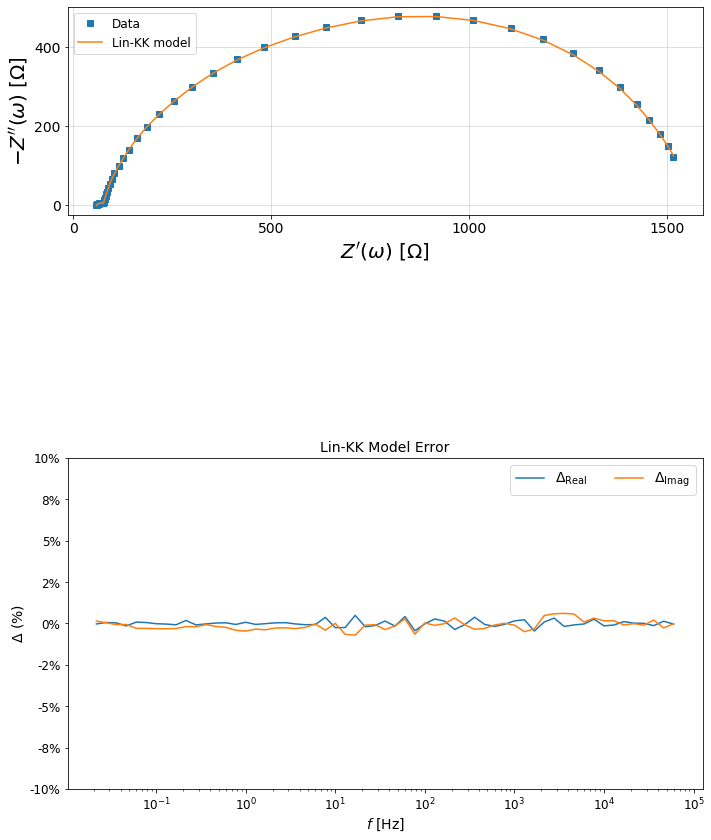

In [4]:
fig = plt.figure(figsize=(10,15))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2,:])
ax2 = fig.add_subplot(gs[2,:])

# plot original data
plot_nyquist(ax1, Z1, fmt='s')

# plot measurement model
plot_nyquist(ax1, Z_linKK, fmt='-', units='\Omega')

ax1.legend(['Data', 'Lin-KK model'], loc=2, fontsize=12)

# Plot residuals
ax2.plot(freqs, res_real, '-', label=r'$\Delta_{\mathrm{Real}}$')
ax2.plot(freqs, res_imag, '-', label=r'$\Delta_{\mathrm{Imag}}$')
ax2.set_title('Lin-KK Model Error', fontsize=14)

ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_ylabel('$\Delta$ $(\%)$', fontsize=14)
ax2.set_xlabel('$f$ [Hz]', fontsize=14)
ax2.set_xscale('log')
ax2.set_ylim(-.1, .1)

ax2.legend(loc=1, fontsize=14, ncol=2)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:.0%}'.format(x) for x in vals])

plt.tight_layout()
plt.show()

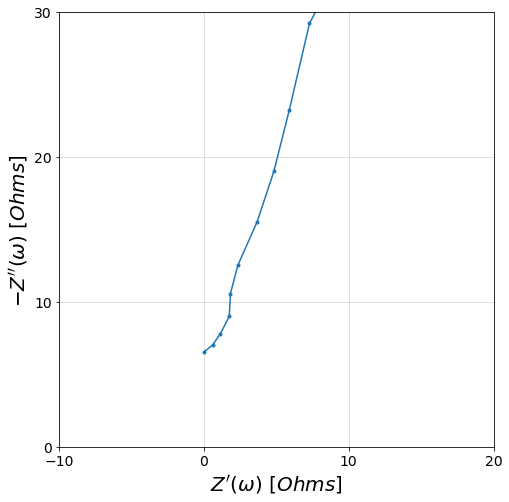

In [5]:
f_adj, Z_adj = freqs[17:], Z1[17:]
# f_adj, Z_adj = freqs, Z1

Z_adj = Z_adj - Z_adj.real[0]

fig, ax = plt.subplots(figsize=(8,8))

plot_nyquist(ax, Z_adj)

ax.set_xlim(-10, 20)
ax.set_ylim(0,30)
plt.show()

### Subtracting a Gerischer admittance from this using tg=0.7 as fit from fr-XAS
### Varying the Rg to see what might be appropriate

f_peak: 0.774 Z_peak: 810.237-608.337j peak symmetry: -9.6084 N_curl: 1             N_Z'_neg: 0
f_peak: 0.774 Z_peak: 787.801-594.981j peak symmetry: -13.3479 N_curl: 1             N_Z'_neg: 0
f_peak: 0.599 Z_peak: 885.987-584.836j peak symmetry: 7.5867 N_curl: 1             N_Z'_neg: 0
f_peak: 0.599 Z_peak: 865.807-575.692j peak symmetry: 3.9307 N_curl: 1             N_Z'_neg: 0
f_peak: 0.599 Z_peak: 847.738-567.365j peak symmetry: 0.7665 N_curl: 0             N_Z'_neg: 0
f_peak: 0.599 Z_peak: 831.503-559.770j peak symmetry: -1.9873 N_curl: 0             N_Z'_neg: 0
f_peak: 0.599 Z_peak: 816.868-552.832j peak symmetry: -4.3964 N_curl: 0             N_Z'_neg: 0
f_peak: 0.599 Z_peak: 803.637-546.484j peak symmetry: -6.5137 N_curl: 0             N_Z'_neg: 0
f_peak: 0.599 Z_peak: 791.645-540.666j peak symmetry: -8.3828 N_curl: 0             N_Z'_neg: 0
f_peak: 0.464 Z_peak: 887.836-535.723j peak symmetry: 12.1409 N_curl: 0             N_Z'_neg: 0
f_peak: 0.464 Z_peak: 876.862-531.655j pea

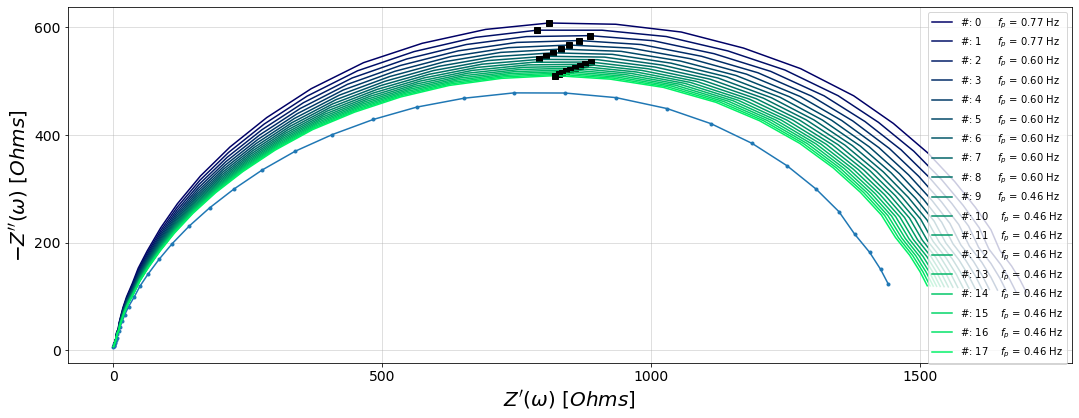

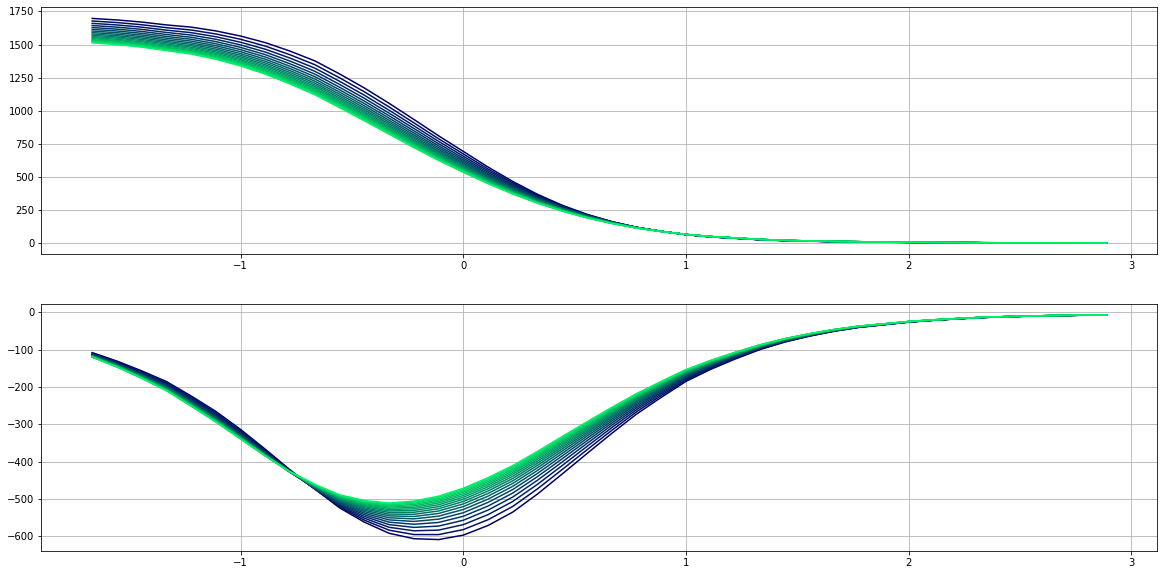

In [8]:
# Returning spectra after subtracting Zg with a range of Rchem values
par_out = IC.sub_Zg_parallel(f_adj, Z_adj, 3.26, [4, 4.5], num=18, show_plot=False)

fig, ax = plt.subplots(figsize=(18, 12))
fig2, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))
plot_nyquist(ax, Z_adj)

for i, Zs in enumerate(par_out):
    min_ind = np.argmin(Zs.imag)
    print("f_peak: {:.3f} Z_peak: {:.3f} peak symmetry: {:.4f} N_curl: {:d} \
            N_Z\'_neg: {:d}".format(f_adj[min_ind], Zs[min_ind],
                                    Zs[min_ind+1].imag - Zs[min_ind-1].imag,
                                    sum(n < 0 for n in np.diff(Zs)),
                                    sum(n < -1 for n in Zs.real)))
    f_p_idx = np.argmin(np.imag(Zs))
    f_p = f_adj[f_p_idx]

    ax.plot(Zs.real, -Zs.imag, label='#: %d \t $f_p$ = %.2f Hz' % (i, f_p),
            c=(0, i/len(par_out), .4))
    ax.plot(Zs[f_p_idx].real, -Zs[f_p_idx].imag, 's',
            c=(0, 0, 0))
    ax1.plot(np.log10(f_adj), Zs.real, label='%.2f Hz' % f_p,
            c=(0, i/len(par_out), .4))
    ax2.plot(np.log10(f_adj), Zs.imag, label='%.2f Hz' % f_p,
            c=(0, i/len(par_out), .4))

#     ax.set_xlim(-80, 300)
#     ax.set_ylim(-80, 300)
    ax1.grid(True)
    ax2.grid(True)
    ax.legend()
# fig.savefig(r'Figures\Berthier Correction\1%O2 Data Zg Subtraction Nyquist', dpi=300, bbox_inches='tight')
# fig2.savefig(r'Figures\Berthier Correction\1%O2 Data Zg Subtraction Bode', dpi=300, bbox_inches='tight')

      fun: 10336.08697473595
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00254659])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 28
      nit: 8
   status: 0
  success: True
        x: array([6137.03098851])


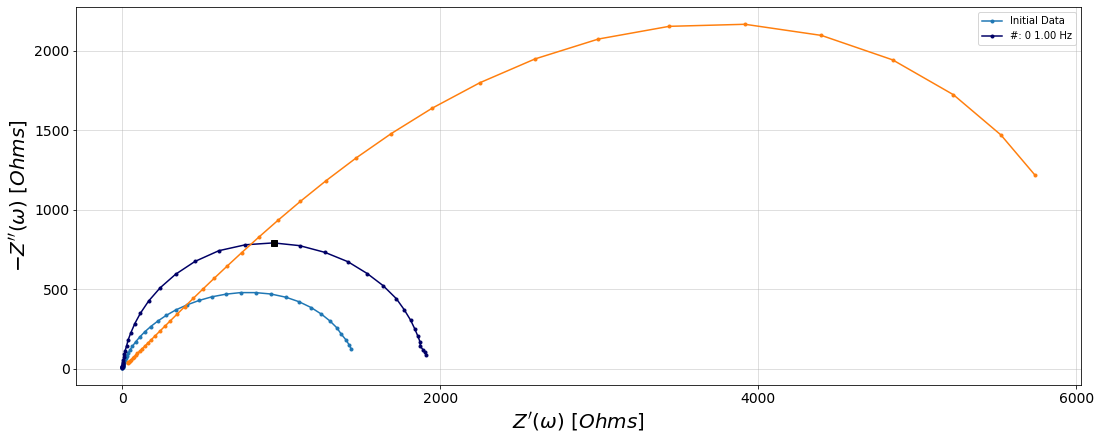

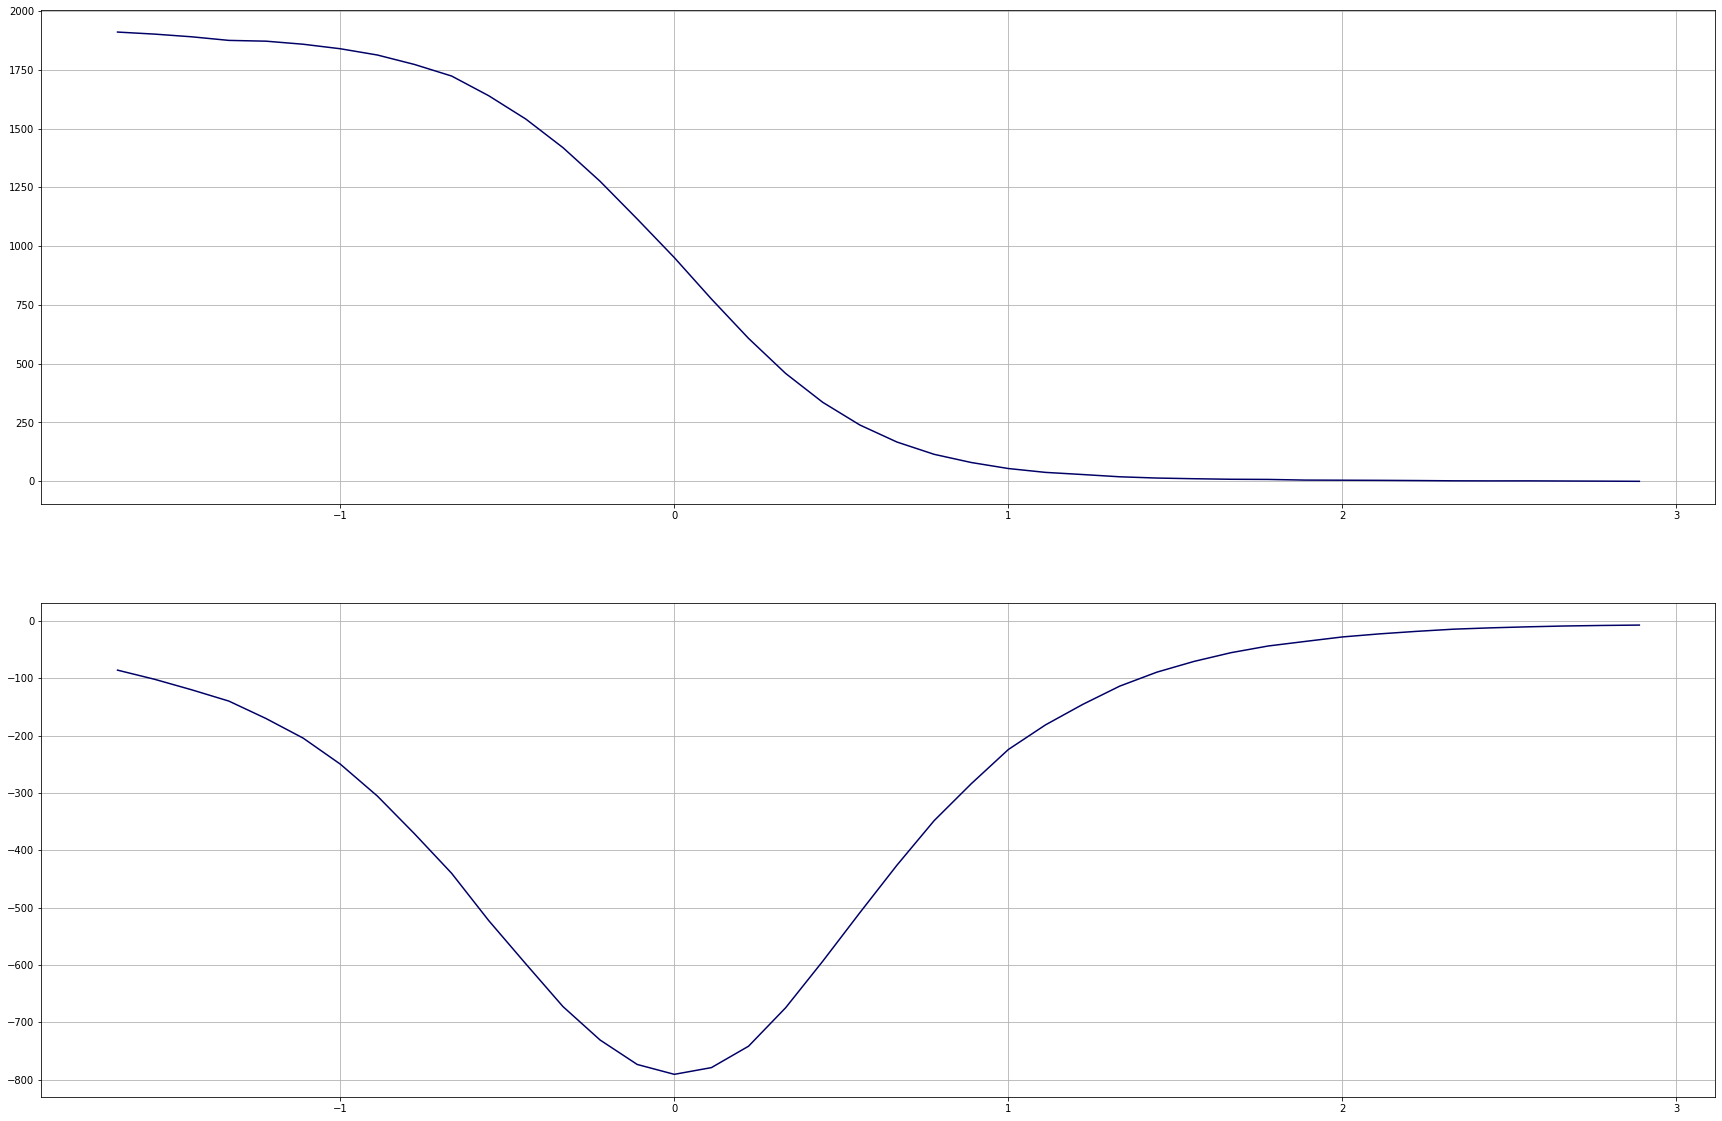

In [9]:
Zg0 = [5500] #, 0.7]
tg0 = 3.275
opts = {'maxiter': 10000}
Zg_fit = minimize(IC.Par_Zg_Res, Zg0, method='L-BFGS-B', args=(f_adj, Z_adj, tg0), options=opts)
print(Zg_fit)

Zadj, axes = IC.sub_Zg_parallel(f_adj, Z_adj, tg0, [Zg_fit.x[0]], num=1)
Zg = G([Zg_fit.x[0], tg0], f_adj)
plot_nyquist(axes[0], Zg)

                        fun: 2251.8442865642273
 lowest_optimization_result:       fun: 2251.8442865642273
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00031832])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 10
      nit: 2
   status: 0
  success: True
        x: array([8451.45049564])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 72
                       nfev: 27708
                        nit: 1000
                          x: array([8451.45049564])


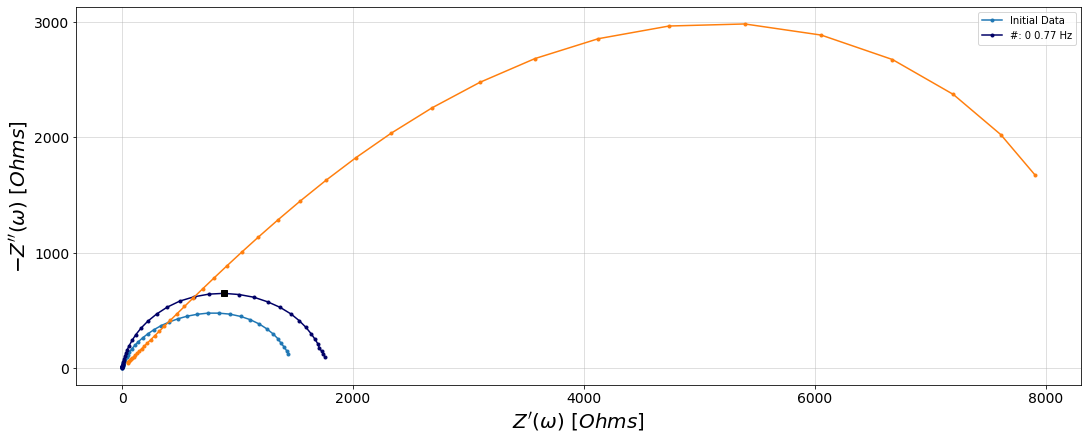

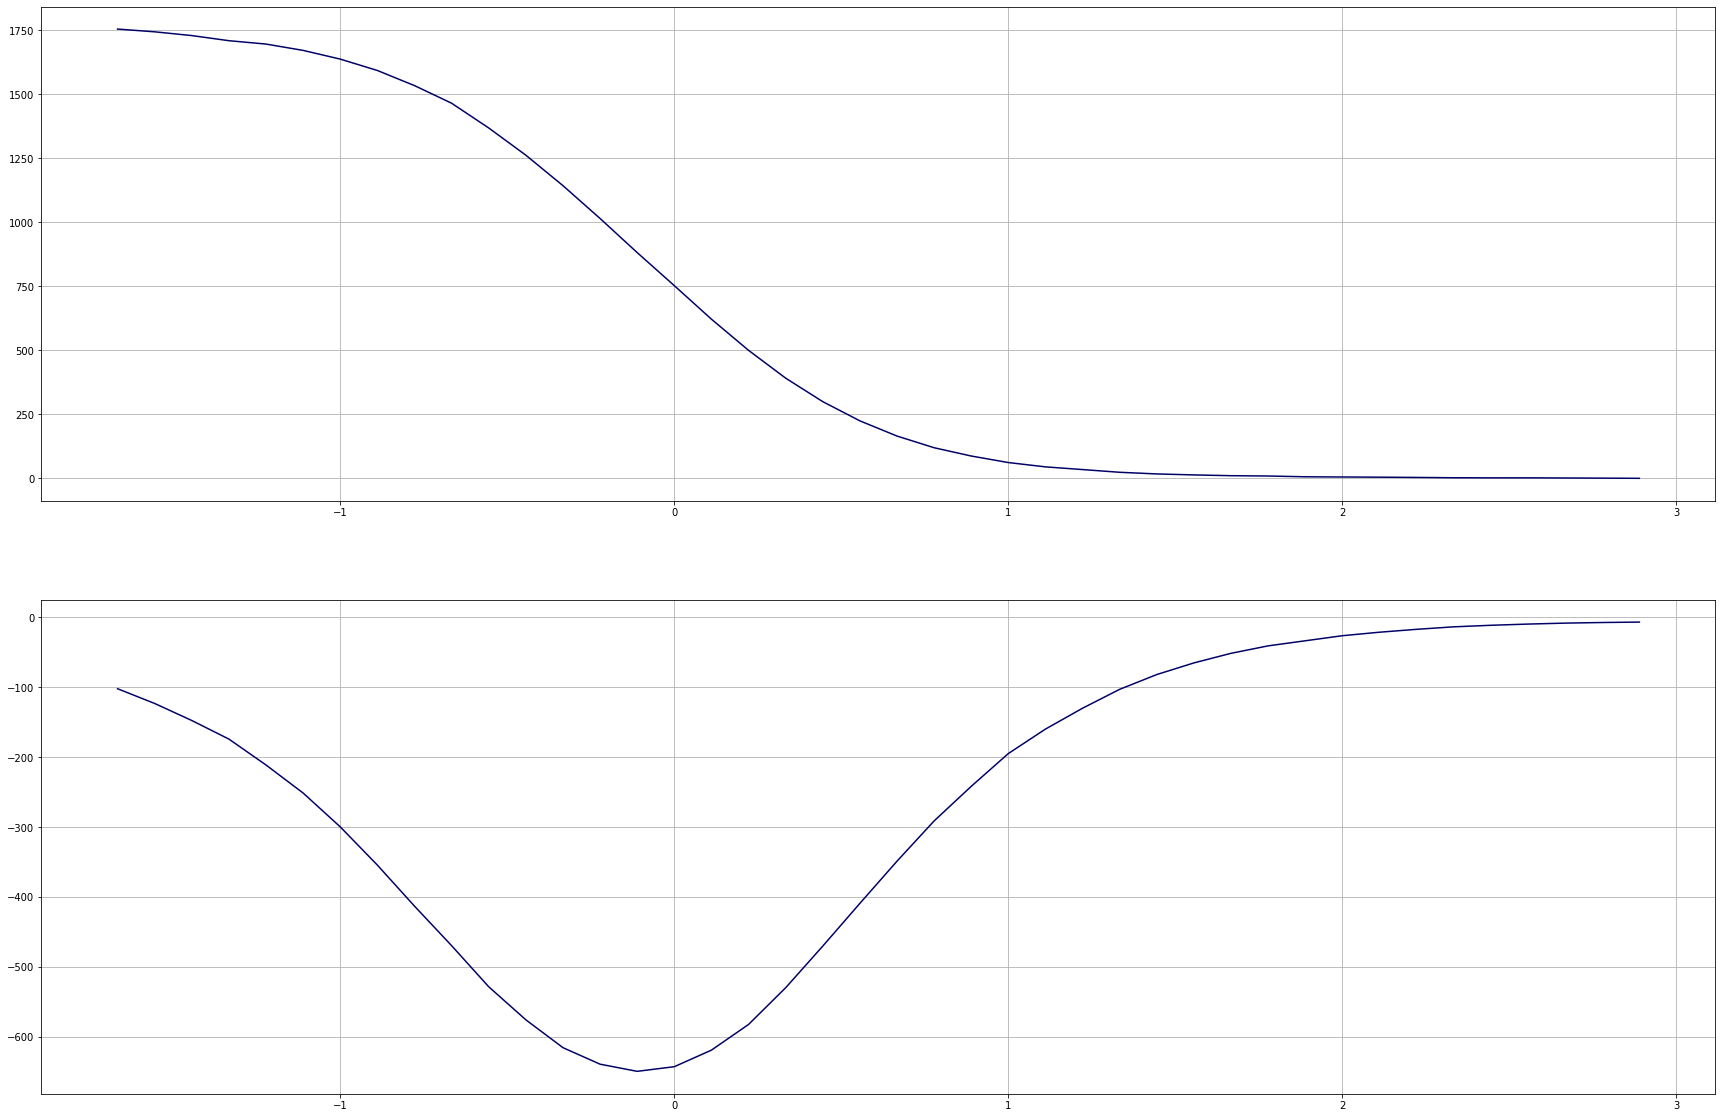

In [16]:
Zg0 = [10500]
tg0 = 3.275

minimizer_args = {'args':(f_adj, Z_adj, tg0), 'method':'L-BFGS-B'}
Zg_fit = optimize.basinhopping(IC.Par_Zg_Res, Zg0, niter=1000, T=5000, minimizer_kwargs=minimizer_args)
print(Zg_fit)

Zadj, axes = IC.sub_Zg_parallel(f_adj, Z_adj, tg0, [Zg_fit.x[0]], num=1)
Zg = G([Zg_fit.x[0], tg0], f_adj)
plot_nyquist(axes[0], Zg)

C:\Users\shadd\OneDrive\Documents\Python\EIS


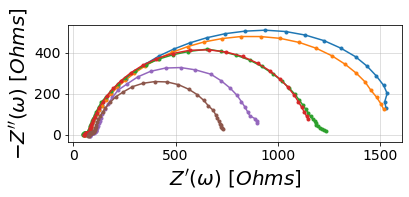

In [115]:
direc = r'\Data'
print(os.getcwd())
all_files=glob.glob(os.getcwd() + direc + '\*.par')
all_files.sort()

fig, ax = plt.subplots()

for file in all_files:
    f, Z = preprocessing.readVersaStudio(file)
    plot_nyquist(ax, Z)

    
# ax.set_xlim(40,150)
# ax.set_ylim(0,100)
plt.show()